In [1]:
import xarray as xr 
import numpy as np
import regionmask
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# borrows heavily from http://www.matteodefelice.name/post/aggregating-gridded-data/
# attempt to apply a mask to the data to generate data suitable for post-processing (country by country mean etc)

In [22]:
# Load the shapefile
PATH_TO_SHAPEFILE = 'shapefiles/ref-nuts-2021-10m.shp/NUTS_RG_10M_2021_4326_LEVL_0.shp/NUTS_RG_10M_2021_4326_LEVL_0.shp'
nuts = gpd.read_file(PATH_TO_SHAPEFILE)

In [122]:
# ozone data in regular lat/lon grid

In [123]:
o3 = xr.open_dataset('cmip6_data/u-be647_ann_mean_surface_level_o3.nc')
# roll longitude from 0-360 to -180 to 180
o3 = o3.assign_coords(longitude=(((o3.longitude + 180) % 360) - 180)).sortby('longitude')
RMM_AIR = 28.97 # g mol-1
RMM_OZONE = 47.997 # g mol-1
MMR_to_PPBV = RMM_AIR/RMM_OZONE*1e9
o3.o3.values = o3.o3.values*MMR_to_PPBV

In [124]:
# CALCULATE MASK
nuts_mask_poly = regionmask.Regions_cls(name = 'nuts_mask', 
                                        numbers = list(range(0,37)), 
                                        names = list(nuts.NUTS_ID), abbrevs = list(nuts.NUTS_ID), 
                                        outlines = list(nuts.geometry.values[i] for i in range(0,37)))
mask = nuts_mask_poly.mask(o3.isel(time = 0).sel(latitude = slice(32, 75), longitude = slice(-30, 50)), lat_name='latitude', lon_name='longitude')


/opt/anaconda3/envs/basemap/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: Using 'Regions_cls' is deprecated, please use 'Regions' instead. Please note that the call signature is different.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [125]:
ID_REGION = 8
print(nuts.NUTS_ID[ID_REGION])
lat = mask.latitude.values
lon = mask.longitude.values
sel_mask = mask.where(mask == ID_REGION).values
id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]

UK


In [126]:
data_to_plot = o3.sel(latitude = slice(id_lat[0], id_lat[-1]), longitude = slice(id_lon[0], id_lon[-1])).compute().where(mask == region)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Change in O3 over UK in ppbv 2015-2100')

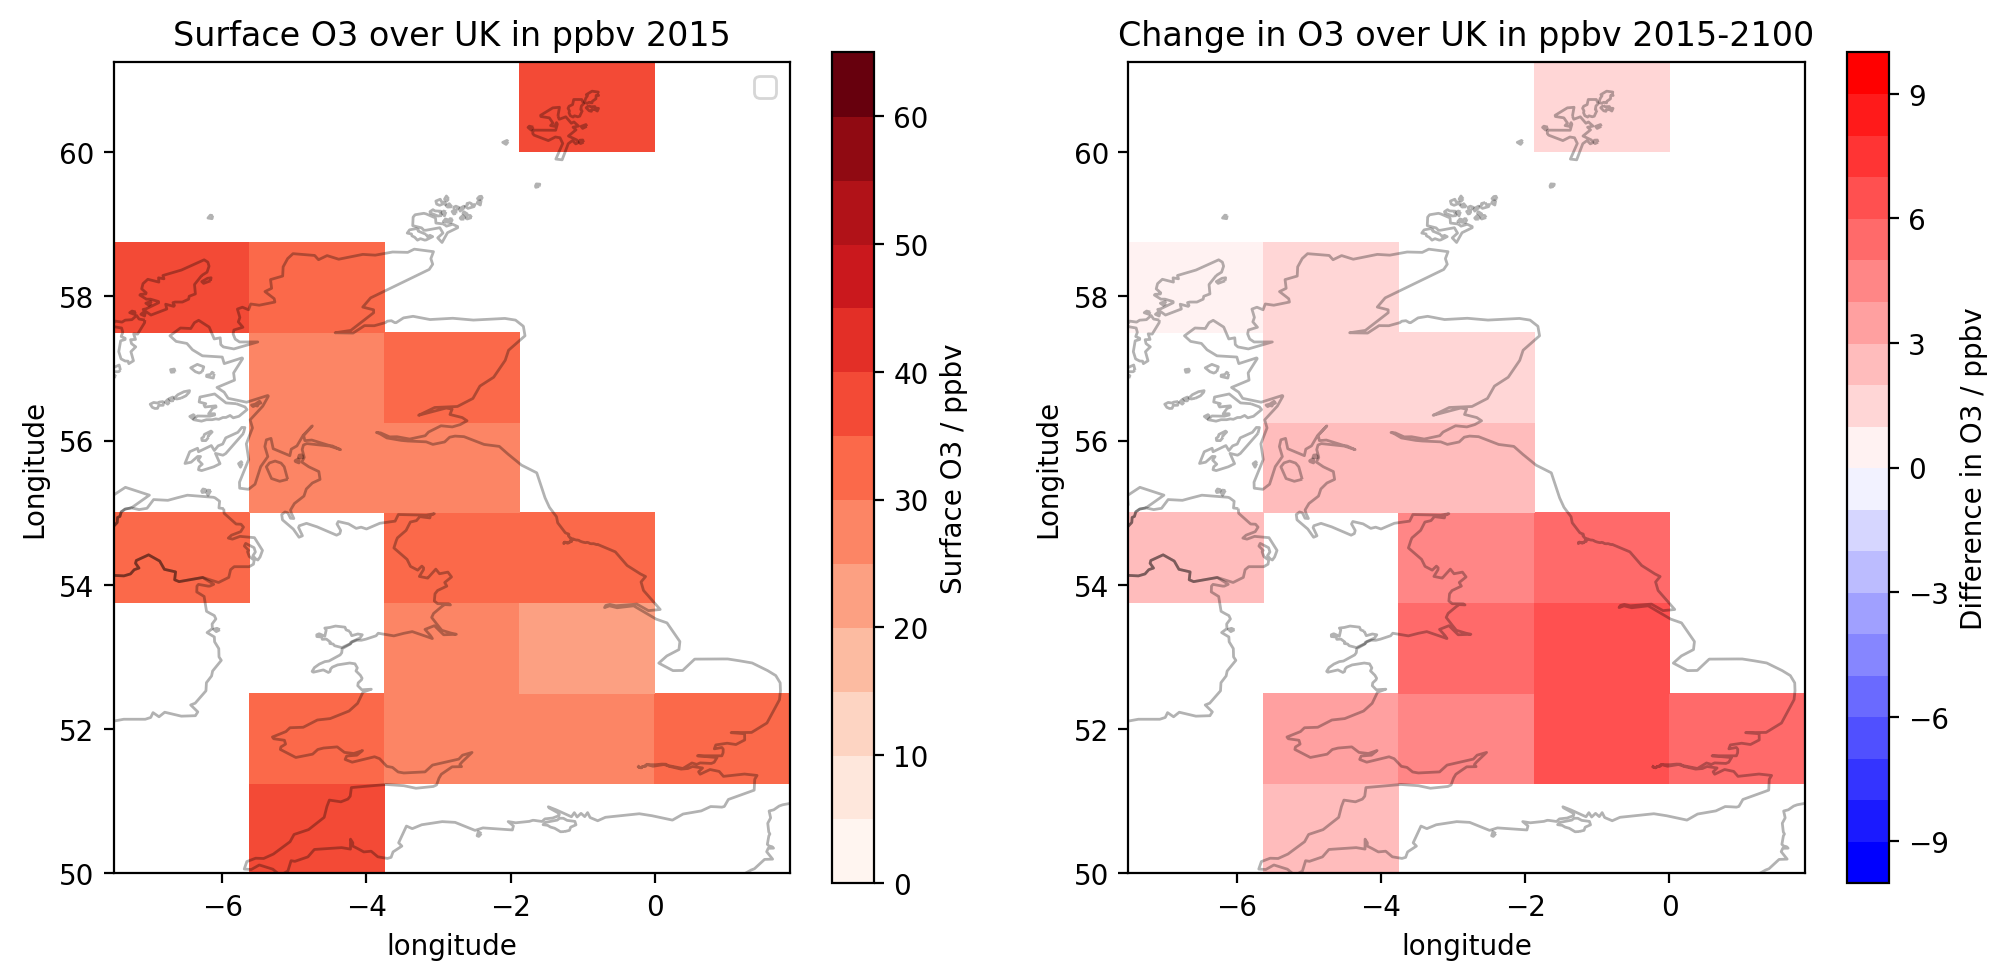

In [127]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(12,5.5), dpi=200)
ax = plt.subplot(1,2,1)
(o3_uk.o3.isel(time = 0)).plot(ax = ax, cmap=plt.get_cmap('Reds'), vmin=0, vmax=65, levels=14,cbar_kwargs={'label': 'Surface O3 / ppbv'})
nuts.plot(ax = ax, alpha = 0.3, facecolor = 'none')
plt.title('Surface O3 over UK in ppbv 2015')
plt.legend()
ax.set_ylabel('Latitude')
ax.set_ylabel('Longitude')
ax = plt.subplot(1,2,2)
(o3_uk.o3.isel(time = 84)-o3_uk.o3.isel(time = 0)).plot(ax = ax, cmap=plt.get_cmap('bwr'), vmin=-10, vmax=10, levels=21, cbar_kwargs={'label': 'Difference in O3 / ppbv'})
nuts.plot(ax = ax, alpha = 0.3, facecolor = 'none')
ax.set_ylabel('Latitude')
ax.set_ylabel('Longitude')
plt.title('Change in O3 over UK in ppbv 2015-2100')
